# MDS 作业

## 准备环境

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces as face
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
from IPython import display

## 加载数据集

In [2]:
data = face(data_home='./data')

In [3]:
array = data['images'][0]

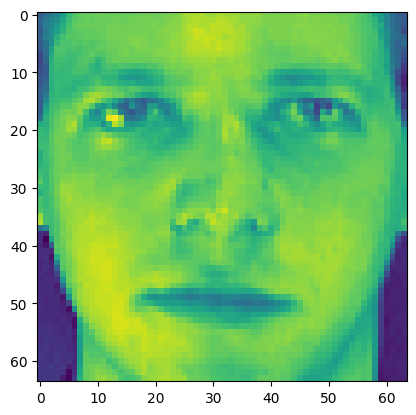

In [4]:
plt.imshow(array)

In [5]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [6]:
len(data['data'][0]), len(data['images'][0]), data['target'][0], data['DESCR'][0]

(4096, 64, 0, '.')

In [7]:
res = data['data'][0] - data['data'][1]

## 距离算法

In [8]:
''' 对于每一张图片，输入为二维已展开为一维的形式 '''
class Distance:
    def _calcDiff(self, a, b):
        # 矩阵运算中间结果
        return a - b
#     def autoConvert(self, a, b):
#         # 自动转换为 tensor
#         if not isinstance(a, np.Tensor):
#             a = np.tensor(a)
#             b = np.tensor(b)
#         return a, b
    def Euclidean(self, a, b):
#         a, b = self.autoConvert(a, b)
        # 欧式距离
        midRes = self._calcDiff(a, b)
        res = np.sqrt(np.sum(midRes ** 2))
        return res
    
    def Manhattan(self, a, b):
#         a, b = self.autoConvert(a, b)
        # 曼哈顿距离
        midRes = self._calcDiff(a, b)
        res = np.sum(np.abs(midRes))
        return res
    
    def DefaultDistance(self, a, b):
        # 默认算法，提供公共接口
#         a, b = self.autoConvert(a, b)
#         res = self.Euclidean(a, b)
        res = self.Manhattan(a, b)
        return res

In [9]:
calc_obj = Distance()

In [10]:
element_0 = data['data'][0]
element_1 = data['data'][1]
calc_obj.Euclidean(element_0, element_1), calc_obj.Manhattan(element_0, element_1), calc_obj.DefaultDistance(element_0, element_1)

(12.699108, 497.8636, 497.8636)

## MDS 算法

### 构建原始距离矩阵

In [11]:
# 建立矩阵
element_count = len(data['data'])
print(element_count)
distance_matrix = np.zeros((element_count, element_count))

400


In [12]:
# 封装迭代器
class DataIterator:
    def __init__(self, data):
        self.data = data
        self.index = 0
        
    def __iter__(self):
        return iter(self.data)
    
#     def __next__(self):
#         if self.index < len(self.data):
#             result = self.data[self.index]
#             self.index += 1
#             return result
#         else:
#             raise StopIteration()

In [13]:
# 封装矩阵迭代器
class MatrixIterator:
    def __init__(self, data):
        self.data = data
        self.data_iter_Row = DataIterator(data)
        self.data_iter_Col = DataIterator(data)
    def getRowIter(self):
        return self.data_iter_Row
    
    def getColIter(self):
        return self.data_iter_Col

In [14]:
data_iter = MatrixIterator(data['data'])

In [15]:
for index, element in enumerate(data_iter.getRowIter()):
    for index2, element2 in enumerate(data_iter.getColIter()):
        if index == index2:
            distance_matrix[index, index2] = 0
        else:
            distance_matrix[index, index2] = distance_matrix[index2, index] = calc_obj.DefaultDistance(element, element2)

In [16]:
print(distance_matrix)

[[  0.         497.86358643 223.68595886 ... 693.97937012 608.0413208
  601.80993652]
 [497.86358643   0.         466.27685547 ... 597.46276855 912.92150879
  709.6239624 ]
 [223.68595886 466.27685547   0.         ... 644.93804932 660.72723389
  613.36364746]
 ...
 [693.97937012 597.46276855 644.93804932 ...   0.         768.01239014
  468.56613159]
 [608.0413208  912.92150879 660.72723389 ... 768.01239014   0.
  563.51239014]
 [601.80993652 709.6239624  613.36364746 ... 468.56613159 563.51239014
    0.        ]]


## 初始化低维*（2 维）*空间坐标

In [17]:
# 正太分布随机空间坐标
dimension = 2
np.random.seed(0)
mapping_matrix = np.random.normal(0, 0.01, size=(element_count, dimension))
# (size=(element_count, dimension))

In [18]:
# 示例结果
print(mapping_matrix[: 10])

[[ 0.01764052  0.00400157]
 [ 0.00978738  0.02240893]
 [ 0.01867558 -0.00977278]
 [ 0.00950088 -0.00151357]
 [-0.00103219  0.00410599]
 [ 0.00144044  0.01454274]
 [ 0.00761038  0.00121675]
 [ 0.00443863  0.00333674]
 [ 0.01494079 -0.00205158]
 [ 0.00313068 -0.00854096]]


### 迭代 —— 计算应力

In [19]:
# 生成映射距离矩阵
mapping_distance = np.zeros((element_count, element_count))

def calc_mapping_distance():
    mapping_distance_iter = MatrixIterator(mapping_matrix)
    for index, element in enumerate(mapping_distance_iter.getRowIter()):
        for index2, element2 in enumerate(mapping_distance_iter.getColIter()):
            if index == index2:
                mapping_distance[index, index2] = 0
            else:
                mapping_distance[index, index2] = mapping_distance[index2, index] =calc_obj.DefaultDistance(element, element2)

calc_mapping_distance()
print(mapping_distance)

[[0.         0.0262605  0.01480941 ... 0.03922124 0.03166722 0.03418837]
 [0.0262605  0.         0.04106991 ... 0.04977546 0.04222144 0.04474259]
 [0.01480941 0.04106991 0.         ... 0.02804866 0.01892793 0.02439535]
 ...
 [0.03922124 0.04977546 0.02804866 ... 0.         0.01111716 0.00503287]
 [0.03166722 0.04222144 0.01892793 ... 0.01111716 0.         0.00746384]
 [0.03418837 0.04474259 0.02439535 ... 0.00503287 0.00746384 0.        ]]


In [20]:
# 应力计算公式
def stress():
    stress = np.zeros((element_count))
    for i in range(element_count):
        for j in range(i + 1, element_count):
            D = distance_matrix[i, j]
            stress[i] += ((mapping_distance[i, j] - D) / D) ** 2
#     stress = torch.pow(mapping_distance - distance_matrix, 2)
    return stress

In [21]:
diff = stress()
diff

array([398.96418839, 397.95848567, 396.96024202, 395.97943254,
       394.9794391 , 393.97281061, 392.97618644, 391.97833338,
       390.97165211, 389.97708337, 388.95333777, 387.97201358,
       386.94917782, 385.97960578, 384.95948053, 383.97861615,
       382.96113058, 381.9792566 , 380.96614966, 379.97865265,
       378.96412023, 377.9513717 , 376.97705335, 375.97006451,
       374.97065244, 373.97673989, 372.97189703, 371.97949537,
       370.97638163, 369.97603213, 368.97612131, 367.96494967,
       366.97817844, 365.96436902, 364.97502267, 363.97816469,
       362.96384597, 361.97555579, 360.97645438, 359.98012565,
       358.96592532, 357.96604852, 356.95319955, 355.96918985,
       354.97275627, 353.97416628, 352.97267762, 351.97706563,
       350.96718819, 349.98028079, 348.9575091 , 347.96983875,
       346.9616856 , 345.98242781, 344.96604446, 343.97184654,
       342.97275423, 341.98297168, 340.98255854, 339.9808455 ,
       338.97755509, 337.97466955, 336.98310508, 335.97

In [22]:
# 定义梯度函数
def stress_grad():
    calc_mapping_distance() # 重新计算 降维距离矩阵
    grad = np.zeros((element_count, dimension))
    for i in range(element_count):
        for j in range(i + 1, element_count):
            D = distance_matrix[i, j]
            common = ((mapping_distance[i, j] - D) / D) * mapping_distance[i, j] / D
            grad[i] += np.array([mapping_matrix[i, 0] - mapping_matrix[j, 0], mapping_matrix[i, 1] - mapping_matrix[j, 1]]) * common
    grad *= 4
    return grad

grad = stress_grad()
print(grad)

[[-1.54672840e-03 -4.20068866e-04]
 [-1.05572935e-03 -2.14342370e-03]
 [-1.78335498e-03  8.85997233e-04]
 [-5.59781537e-04  6.08181479e-05]
 [ 1.35323093e-05 -2.89875680e-04]
 [-1.62577279e-04 -1.01956183e-03]
 [-5.46822252e-04 -1.24811239e-04]
 [-3.24003560e-04 -2.53473417e-04]
 [-1.09172995e-03  1.01384054e-04]
 [-2.58264881e-04  4.88623553e-04]
 [ 2.54371561e-03 -8.24284650e-04]
 [-6.87015296e-04  4.96346488e-04]
 [-2.66032803e-03  1.61912760e-03]
 [-8.44905618e-05  6.77117005e-05]
 [-1.54986714e-03 -1.46532561e-03]
 [-1.61289484e-04 -2.84259938e-04]
 [ 7.40206157e-04  1.73744666e-03]
 [ 1.49715845e-04 -1.38299150e-04]
 [-1.10799749e-03 -1.05596553e-03]
 [ 1.79721133e-04  1.46734552e-04]
 [ 8.41365694e-04  1.20546789e-03]
 [ 1.75675497e-03 -2.22916536e-03]
 [ 2.77068224e-04  2.33958471e-04]
 [ 8.70145482e-04 -6.71759840e-04]
 [ 1.09878559e-03  1.03216576e-04]
 [ 5.16285325e-04 -3.00996741e-04]
 [ 3.36155342e-04  8.29012346e-04]
 [-2.89606935e-05 -2.99124686e-04]
 [-1.04806020e-04 -2

### 梯度下降优化

In [23]:
# 定义优化算法
def sgd(params, lr, grad):
    '''梯度下降'''
    for param in params:
        param -= lr * grad

In [24]:
# 学习率
lr = 1e-3
num_epoches = 100
for epoch in range(num_epoches):
    grad = stress_grad()
    sgd([mapping_matrix], lr, grad)
    print(epoch ,'代完成')
    
print('完成')

0 代完成
1 代完成
2 代完成
3 代完成
4 代完成
5 代完成
6 代完成
7 代完成
8 代完成
9 代完成
10 代完成
11 代完成
12 代完成
13 代完成
14 代完成
15 代完成
16 代完成
17 代完成
18 代完成
19 代完成
20 代完成
21 代完成
22 代完成
23 代完成
24 代完成
25 代完成
26 代完成
27 代完成
28 代完成
29 代完成
30 代完成
31 代完成
32 代完成
33 代完成
34 代完成
35 代完成
36 代完成
37 代完成
38 代完成
39 代完成
40 代完成
41 代完成
42 代完成
43 代完成
44 代完成
45 代完成
46 代完成
47 代完成
48 代完成
49 代完成
50 代完成
51 代完成
52 代完成
53 代完成
54 代完成
55 代完成
56 代完成
57 代完成
58 代完成
59 代完成
60 代完成
61 代完成
62 代完成
63 代完成
64 代完成
65 代完成
66 代完成
67 代完成
68 代完成
69 代完成
70 代完成
71 代完成
72 代完成
73 代完成
74 代完成
75 代完成
76 代完成
77 代完成
78 代完成
79 代完成
80 代完成
81 代完成
82 代完成
83 代完成
84 代完成
85 代完成
86 代完成
87 代完成
88 代完成
89 代完成
90 代完成
91 代完成
92 代完成
93 代完成
94 代完成
95 代完成
96 代完成
97 代完成
98 代完成
99 代完成
完成


In [25]:
# 降维距离矩阵结果
calc_mapping_distance()
print('降维距离矩阵')
print(mapping_distance)

降维距离矩阵
[[0.         0.02648367 0.0149651  ... 0.03941941 0.03186531 0.03438648]
 [0.02648367 0.         0.04144877 ... 0.05009815 0.04254406 0.04506522]
 [0.0149651  0.04144877 0.         ... 0.02831794 0.01901833 0.02466454]
 ...
 [0.03941941 0.05009815 0.02831794 ... 0.         0.01111728 0.00503293]
 [0.03186531 0.04254406 0.01901833 ... 0.01111728 0.         0.00746388]
 [0.03438648 0.04506522 0.02466454 ... 0.00503293 0.00746388 0.        ]]


In [26]:
# 位置结果
print('降维空间')
print(mapping_matrix)

降维空间
[[ 1.77963257e-02  4.04387416e-03]
 [ 9.89386394e-03  2.26250802e-02]
 [ 1.88553872e-02 -9.86216847e-03]
 [ 9.55713325e-03 -1.51971117e-03]
 [-1.03355997e-03  4.13510068e-03]
 [ 1.45678504e-03  1.46452684e-02]
 [ 7.66535407e-03  1.22927636e-03]
 [ 4.47119598e-03  3.36220234e-03]
 [ 1.50506253e-02 -2.06181271e-03]
 [ 3.15664392e-03 -8.59011110e-03]
 [-2.57866608e-02  6.61940104e-03]
 [ 8.71347998e-03 -7.47162793e-03]
 [ 2.29663562e-02 -1.47073209e-02]
 [ 4.66069954e-04 -1.87866999e-03]
 [ 1.54841028e-02  1.48413484e-02]
 [ 1.56568418e-03  3.81017712e-03]
 [-8.95248760e-03 -1.99831362e-02]
 [-3.49417336e-03  1.57736449e-03]
 [ 1.24145149e-02  1.21301415e-02]
 [-3.89133673e-03 -3.03780252e-03]
 [-1.05703040e-02 -1.43216854e-02]
 [-1.72401471e-02  1.97328848e-02]
 [-5.12438529e-03 -4.40428667e-03]
 [-1.26155338e-02  7.84249844e-03]
 [-1.62495392e-02 -2.13781444e-03]
 [-9.00657941e-03  3.89926700e-03]
 [-5.14188927e-03 -1.18897663e-02]
 [-2.78921212e-04  4.31335628e-03]
 [ 6.75700916e-

## 可视化

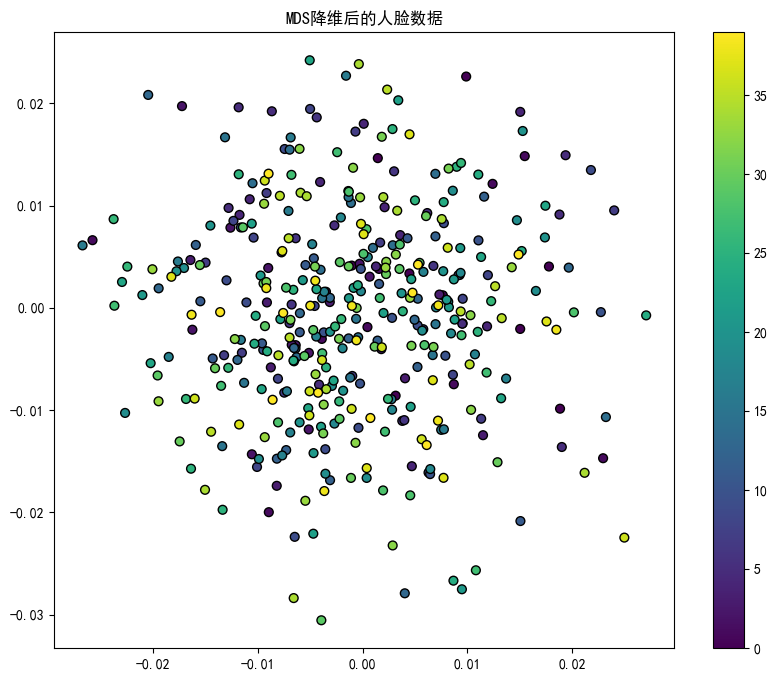

In [27]:
# 设置中文支持的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 可视化降维后的人脸数据
plt.figure(figsize=(10, 8))
plt.scatter(mapping_matrix[:, 0], mapping_matrix[:, 1], c=data['target'], cmap='viridis', edgecolor='k', s=40)
plt.colorbar()
plt.title('MDS降维后的人脸数据')
plt.show()

## sklearn 库实现参考

In [28]:
import sklearn
from sklearn.datasets import fetch_olivetti_faces
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

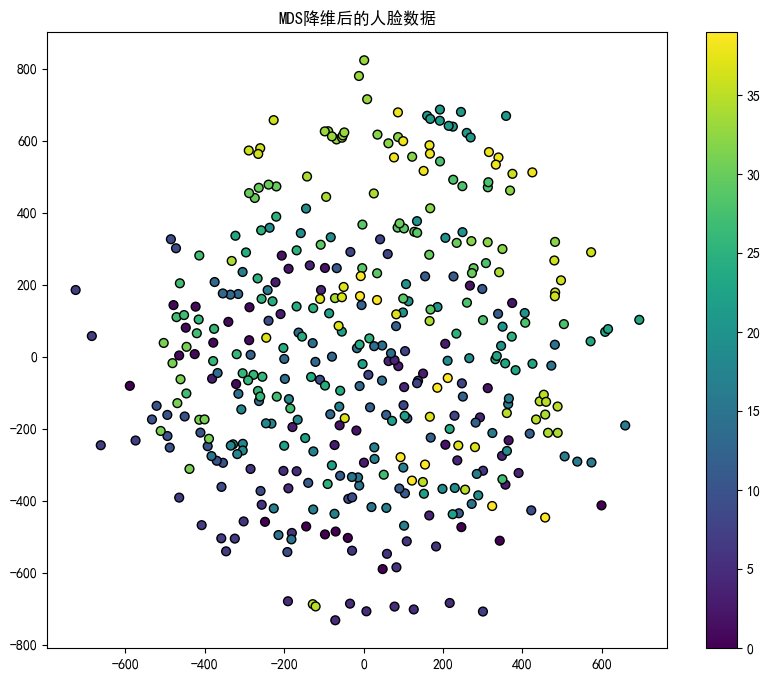

In [29]:
# 设置中文支持的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 加载Olivetti人脸数据集
faces = fetch_olivetti_faces(data_home='./data/')
X = faces.data

# 计算人脸之间的距离矩阵
# distances = sklearn.metrics.pairwise.euclidean_distances(X)
distances = sklearn.metrics.pairwise.manhattan_distances(X)

# 创建MDS模型并拟合数据
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, max_iter=3000)
X_mds = mds.fit_transform(distances)

# 可视化降维后的人脸数据
plt.figure(figsize=(10, 8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=faces.target, cmap='viridis', edgecolor='k', s=40)
plt.colorbar()
plt.title('MDS降维后的人脸数据')
plt.show()